# 종목별 테스트
 - 독립변수(모집단) : 기업이름으로 검색한 3~5월 사이의 뉴스데이터
 - 종속변수 : 뉴스의 발행 시점으로부터 몇 분뒤의 평균 기울기

In [1]:
import os
import pandas as pd
import numpy as np
import glob
from newstock.news import Newstock

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [3]:
import sklearn.metrics as m

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, text='text'):
        self.text = text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.text]

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class Buy_Sell_transformer_slope(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, cut_percent=0.2):
        self.cut_percent = 1-cut_percent

    def fit(self, y):
        return self

    def transform(self, y):
        y = y.apply(lambda x: x.coef_[0][0])
        cut_value = y.quantile(self.cut_percent)
        print(cut_value)
        y = pd.cut(y, bins=[-np.inf, cut_value, np.inf], labels=['nothing','buy'])
        return y

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test <= data[date_column].max().date() + eval('relativedelta('+self.freq+'=1)'):
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"<= day <" , end_train, ", Test period", start_test, "<= day <", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [10]:
names = os.listdir('./stock_data/stock_article0301_0531/article/')

In [11]:
data = {}
for name in names:
    print(name)
    ns = Newstock(name)
    data[name] = {'X' : ns.news_data_with_price, 'y' : ns.get_slope_label(minutes=60)}

KB금융
LG생활건강
LG화학
NAVER
POSCO
SK
SK텔레콤
SK하이닉스
기아차
삼성SDI
삼성물산
삼성바이오로직스
삼성에스디에스
삼성전자
셀트리온
신한지주
엔씨소프트
카카오
현대모비스
현대차


In [12]:
data['현대차']['X']['min_arrays'].agg(len)

47      60
48      60
49      60
50      60
51      60
        ..
8217    60
8218    60
8219    60
8220    60
8221    46
Name: min_arrays, Length: 3272, dtype: int64

In [13]:
(data['현대차']['X']['min_arrays'].agg(len) == 60).sum()

2738

In [14]:
len(data['현대차']['X'])

3272

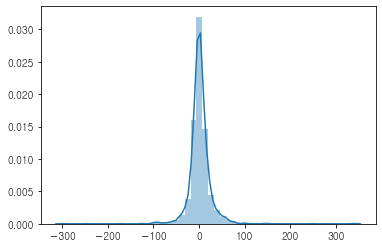

In [15]:
sns.distplot(data['현대차']['y'].apply(lambda x: x.coef_[0][0]))

In [16]:
from sklearn.linear_model import LinearRegression

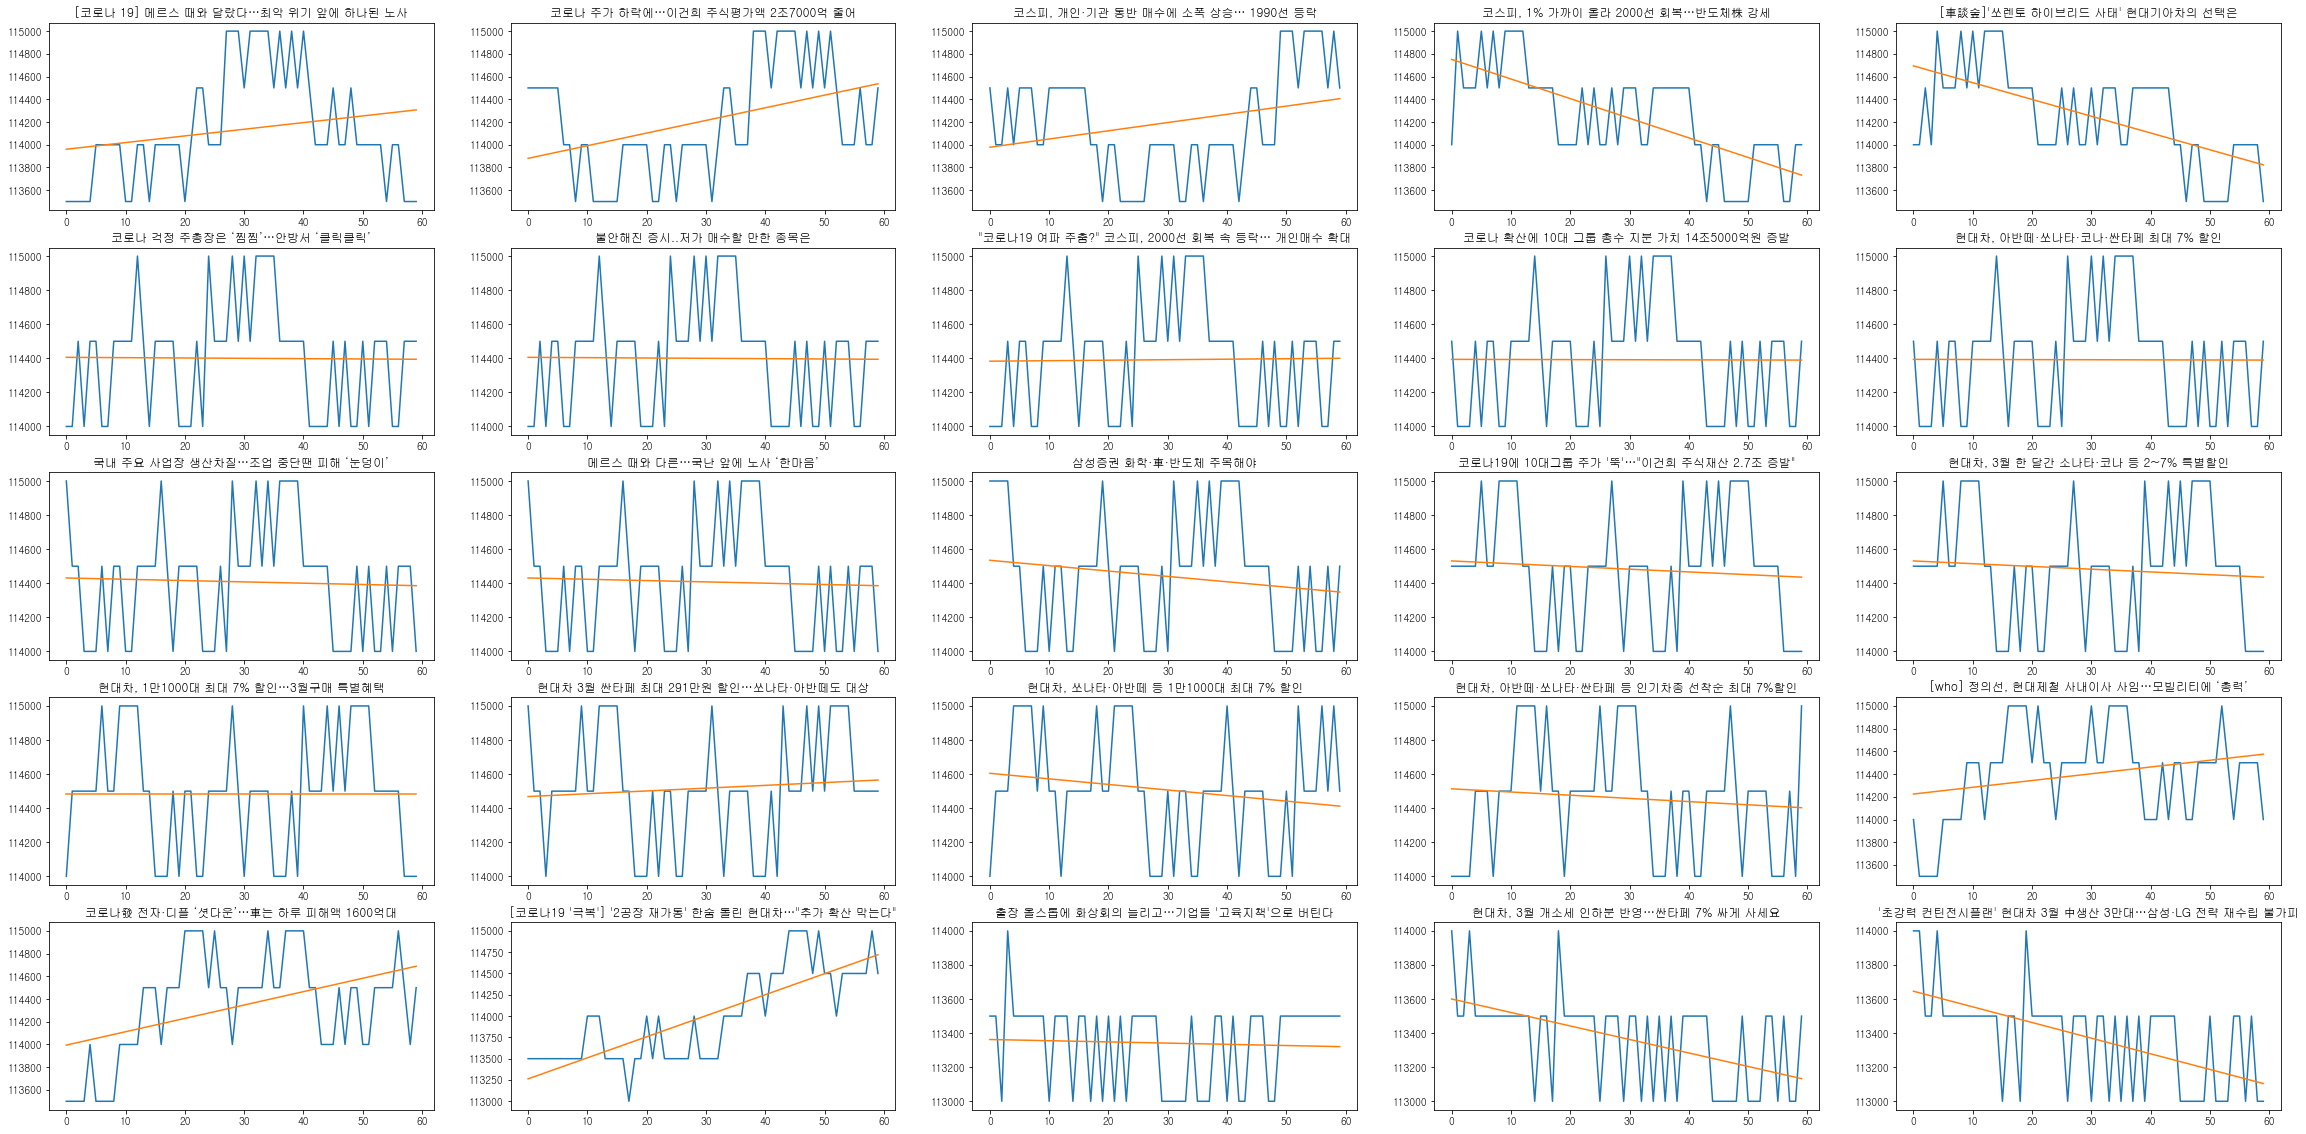

In [18]:
fig, ax = plt.subplots(5, 5, figsize=(40, 20))
n = 10
tmp_X = data['현대차']['X']
tmp_y = data['현대차']['y']

for i in range(len(ax)):
    for j in range(len(ax[0])):
        row = tmp_X.iloc[n]
        lr = tmp_y.iloc[n]
        
        ax[i][j].plot(row['min_arrays'])
        ax[i][j].plot(lr.predict(np.array(range(len(row['min_arrays']))).reshape(-1, 1)))
        
        tmp_str = row['title']
        ax[i][j].set_title(tmp_str)
        n += 1

In [137]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

test_X = ['good good girl', 'bad bad boy', 'good good boy', 'bad bad girl', 'not good girl']
test_y = [1, 0, 1, 0, 0]

In [138]:
cvectorizer = CountVectorizer()
vec_X = cvectorizer.fit_transform(test_X)

In [139]:
cvectorizer.vocabulary_

{'good': 3, 'girl': 2, 'bad': 0, 'boy': 1, 'not': 4}

In [140]:
nb = MultinomialNB(alpha=1.0e-10)
nb.fit(vec_X, test_y)

MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)

In [153]:
nb.feature_log_prob_

array([[ -0.81093022,  -2.19722458,  -1.5040774 ,  -2.19722458,
         -2.19722458],
       [-24.8176104 ,  -1.79175947,  -1.79175947,  -0.40546511,
        -24.8176104 ]])

In [157]:
nb.predict_proba(cvectorizer.transform(["good girl boy"]))

array([[0.18181818, 0.81818182]])

In [149]:
nb.predict_proba(cvectorizer.transform(["good good girl"])).sum()

0.9999999999999999

In [145]:
nb.predict_proba(cvectorizer.transform(["good good good good good good good good good good good good good good good girl"]))

array([[4.25364499e-12, 1.00000000e+00]])

In [114]:
z = np.array(cvectorizer.vocabulary_.keys()), np.take(nb.feature_log_prob_[1, :], list(cvectorizer.vocabulary_.values()))

In [160]:
z

(array(dict_keys(['good', 'girl', 'bad', 'boy']), dtype=object),
 array([-0.69314718, -1.60943791, -2.30258509, -1.60943791]))

In [211]:
y = data['현대차']['y'].apply(lambda x: x.coef_[0][0])

In [216]:
y.describe()

count    3272.000000
mean        2.032036
std        30.285585
min      -300.000000
25%       -10.105673
50%         1.134594
75%        13.620690
max       340.000000
dtype: float64

In [220]:
y.quantile(0.8)

17.56618464961068

In [221]:
cutted = pd.cut(y, bins=[-np.inf, y.quantile(0.8), np.inf], labels=['nothing','buy'])

In [222]:
cutted

47          buy
48          buy
49      nothing
50      nothing
51      nothing
         ...   
8217    nothing
8218    nothing
8219    nothing
8220    nothing
8221    nothing
Length: 3272, dtype: category
Categories (2, object): [nothing < buy]

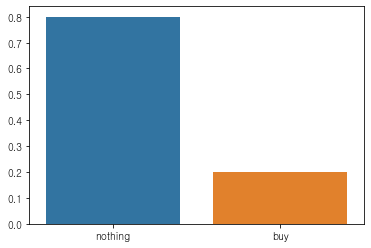

In [223]:
sns.barplot(x = cutted.value_counts().index, y = cutted.value_counts()/len(cutted))

In [196]:
data['현대차']['y'].apply(lambda x: x.coef_[0][0])

47      46.051168
48      67.296997
49      -2.892102
50      -2.892102
51      -5.561735
          ...    
8217     4.293660
8218   -15.483871
8219   -30.233593
8220   -23.203560
8221   -16.774194
Length: 3272, dtype: float64

In [19]:
Buy_Sell_transformer_slope(0.2).transform(data['현대차']['y']).value_counts()

12.984717977215901


nothing    2617
buy         655
dtype: int64

In [20]:
def run(x, y, train_period=60, test_period=29, cut_percent=0.2):
    y_process = Pipeline([
        ('Buy_Sell_transformer_slope', Buy_Sell_transformer_slope(cut_percent)),
    ])

    x_process = Pipeline([
        ('selector', TextSelector()),
        ('counter', CountVectorizer()),
    ])

    pipeline = Pipeline([
                    ('process', x_process),
                    ('clf', MultinomialNB())
                   ])
    
    tscv = TimeBasedCV(train_period=train_period, test_period=test_period, freq='days')
    cv_sets = tscv.split(x.reset_index(drop=True), validation_split_date=None, date_column='timestamps', gap=0)
    
    pipeline.fit(x.iloc[cv_sets[0][0]], y_process.transform(y).iloc[cv_sets[0][0]])
    
    y_true = y_process.transform(y).iloc[cv_sets[0][1]]
    y_pred_prob = pipeline.predict_proba(x.iloc[cv_sets[0][1]])[:, 0]
    y_pred = pipeline.predict(x.iloc[cv_sets[0][1]])
    
    fpr, tpr, _ = m.roc_curve(y_true, y_pred_prob, pos_label=['buy'])
    roc_auc = m.auc(fpr, tpr)

    roc = m.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')    
    conf = m.plot_confusion_matrix(pipeline, x.iloc[cv_sets[0][1]], y_true,
                                   display_labels=['buy', 'nothing'], normalize=None)
    
    prf = m.precision_recall_fscore_support(y_true, y_pred, labels=['buy'])
    
    return conf, roc, prf

In [21]:
cut_percent = 0.3

Train period: 2020-03-03 <= day < 2020-05-02 , Test period 2020-05-02 <= day < 2020-05-28 # train records 32 , # test records 17
9.80550152820228
9.80550152820228


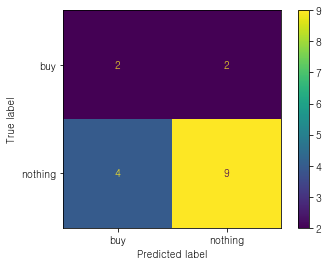

In [22]:
x, y = data["삼성에스디에스"]['X'], data["삼성에스디에스"]['y'] 
conf, roc, prf = run(x, y, train_period=60, test_period=26, cut_percent=cut_percent)

precision: [0.33333333]  recall: [0.5]  f1: [0.4]


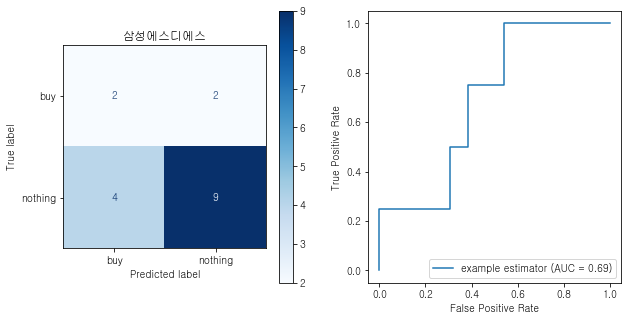

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

roc.plot(ax=ax[1])
conf.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("삼성에스디에스")
print('precision:', prf[0], ' recall:', prf[1], ' f1:', prf[2])

POSCO
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 99 , # test records 39
12.452070019449849
12.452070019449849
삼성바이오로직스
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 811 , # test records 413
43.27868852459016
43.27868852459016
기아차
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 1171 , # test records 536
1.9227563212003336
1.9227563212003336
SK텔레콤
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 938 , # test records 549
12.875798833009178
12.875798833009178
NAVER
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 393 , # test records 239
17.55626562934149
17.55626562934149
신한지주
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 344 , # test recor

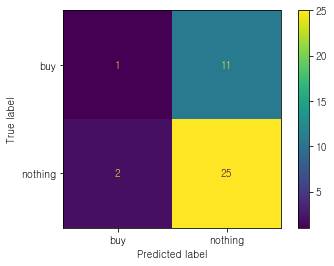

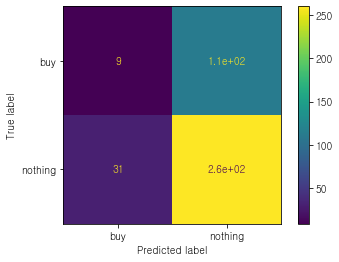

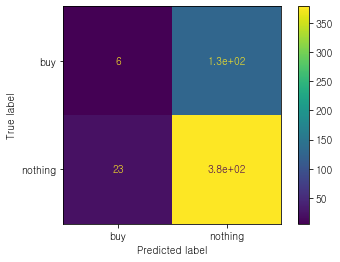

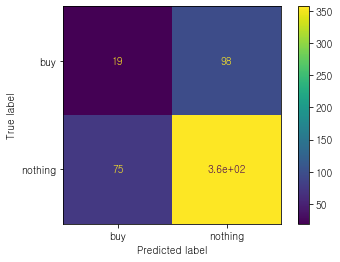

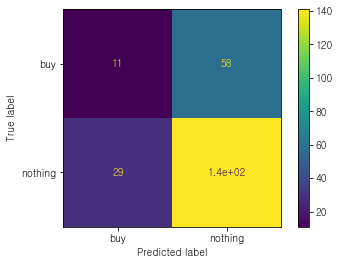

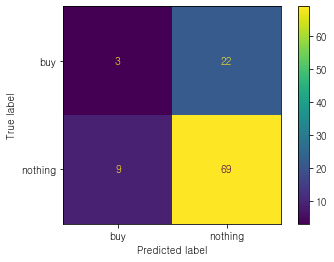

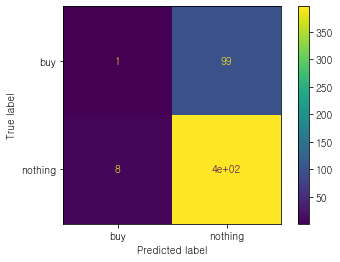

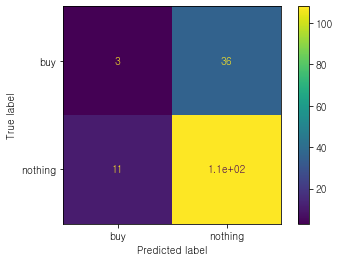

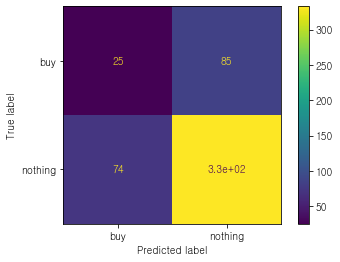

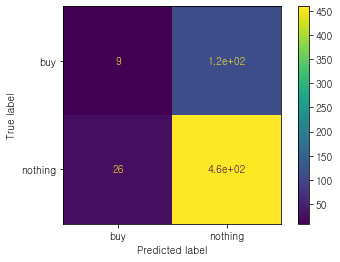

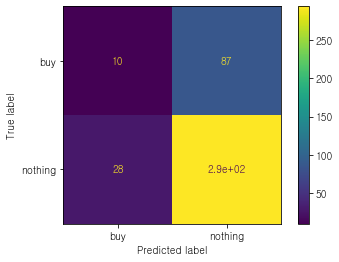

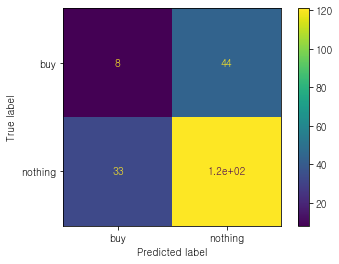

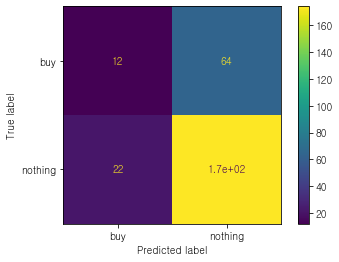

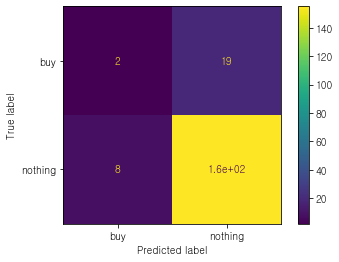

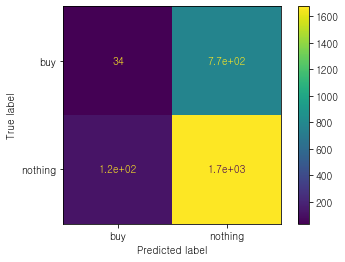

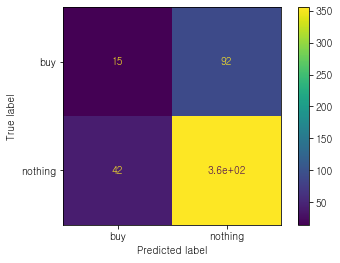

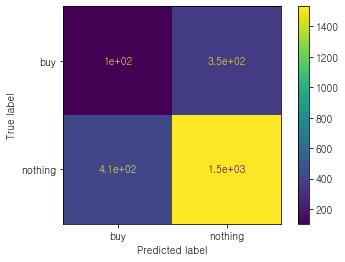

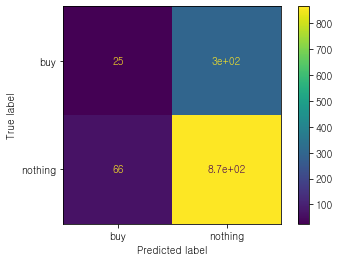

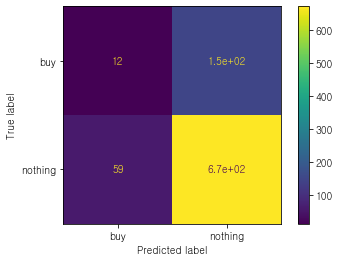

In [44]:
confs = []
rocs = []
prfs = []

keys = list(set(data.keys())-set(['삼성에스디에스']))

for name in keys:
    print(name)
    x, y = data[name]['X'], data[name]['y']
    conf, roc, prf = run(x, y, cut_percent=cut_percent)
    confs.append(conf)
    rocs.append(roc)
    prfs.append(prf)

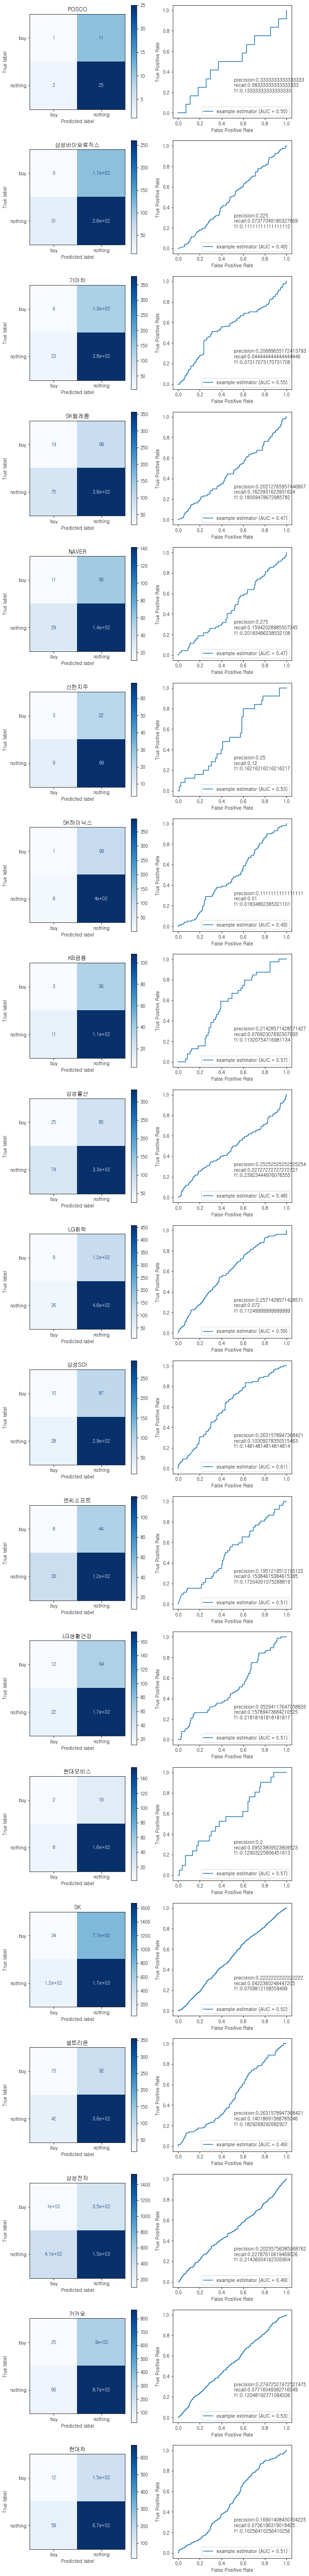

In [45]:
fig, ax = plt.subplots(len(confs), 2, figsize=(10, 100))

for i, key in enumerate(keys):
    rocs[i].plot(ax=ax[i][1])
    confs[i].plot(ax=ax[i][0], cmap=plt.cm.Blues)
    ax[i][0].set_title(key)
    text = ' precision:'+str(prfs[i][0][0]) + '\n recall:'+str(prfs[i][1][0])+'\n f1:'+str(prfs[i][2][0])
    ax[i][1].text(0.5, 0.2, text)
#    print('precision:', prfs[i][0], ' recall:', prfs[i][1], ' f1:', prfs[i][2])

In [46]:
res = pd.DataFrame([keys, prfs]).transpose()

In [47]:
res

,0,1
0,POSCO,"([0.3333333333333333], [0.08333333333333333], ..."
1,삼성바이오로직스,"([0.225], [0.07377049180327869], [0.1111111111..."
2,기아차,"([0.20689655172413793], [0.044444444444444446]..."
3,SK텔레콤,"([0.20212765957446807], [0.1623931623931624], ..."
4,NAVER,"([0.275], [0.15942028985507245], [0.2018348623..."
5,신한지주,"([0.25], [0.12], [0.16216216216216217], [25])"
6,SK하이닉스,"([0.1111111111111111], [0.01], [0.018348623853..."
7,KB금융,"([0.21428571428571427], [0.07692307692307693],..."
8,삼성물산,"([0.25252525252525254], [0.22727272727272727],..."
9,LG화학,"([0.2571428571428571], [0.072], [0.11249999999..."


In [48]:
res['f1'] = res.loc[:, 1].apply(lambda x: x[2][0])

In [49]:
res.iloc[res['f1'].argsort(), [0, 2]][::-1]

,0,f1
8,삼성물산,0.239234
12,LG생활건강,0.218182
16,삼성전자,0.214360
4,NAVER,0.201835
15,셀트리온,0.182927
3,SK텔레콤,0.180095
11,엔씨소프트,0.172043
5,신한지주,0.162162
10,삼성SDI,0.148148
0,POSCO,0.133333


LG생활건강
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 735 , # test records 272
70.80855793275909
70.80855793275909
삼성물산
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 1015 , # test records 517
7.340168020528582
7.340168020528582


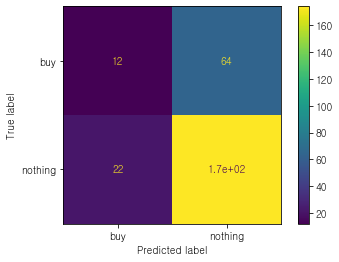

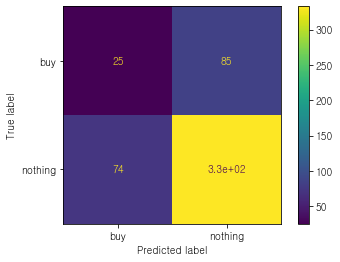

In [50]:
confs = []
rocs = []
prfs = []

keys = ['LG생활건강', '삼성물산']

for name in keys:
    print(name)
    x, y = data[name]['X'], data[name]['y']
    conf, roc, prf = run(x, y, cut_percent=cut_percent)
    confs.append(conf)
    rocs.append(roc)
    prfs.append(prf)

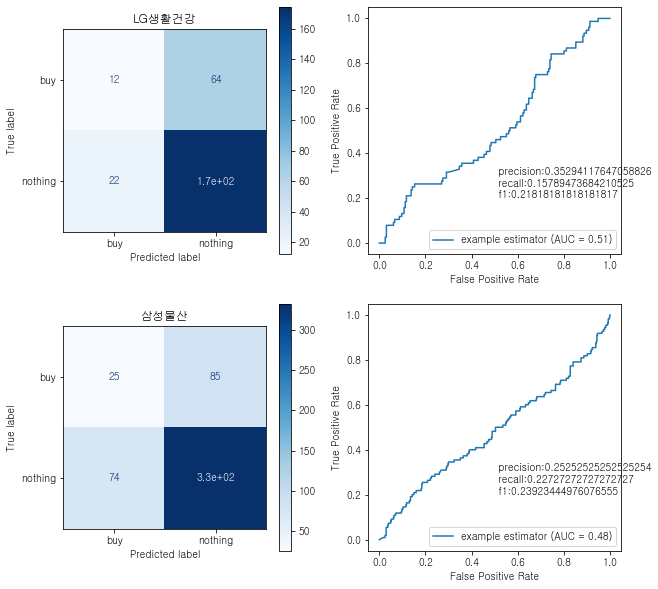

In [51]:
fig, ax = plt.subplots(len(confs), 2, figsize=(10, 10))

for i, key in enumerate(keys):
    rocs[i].plot(ax=ax[i][1])
    confs[i].plot(ax=ax[i][0], cmap=plt.cm.Blues)
    ax[i][0].set_title(key)
    text = ' precision:'+str(prfs[i][0][0]) + '\n recall:'+str(prfs[i][1][0])+'\n f1:'+str(prfs[i][2][0])
    ax[i][1].text(0.5, 0.2, text)
#    print('precision:', prfs[i][0], ' recall:', prfs[i][1], ' f1:', prfs[i][2])

# 전체 뉴스데이터 종합

C:\Users\ufoio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 26608 , # test records 12408
17.0880800222284
17.0880800222284


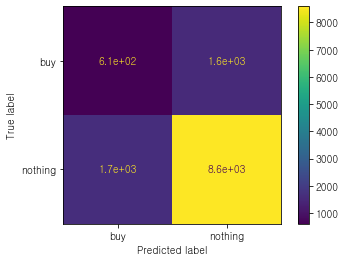

In [52]:
x_all = pd.DataFrame()
y_all = pd.Series().astype(float)

for key in data.keys():
    x_tmp, y_tmp = data[key]['X'], data[key]['y']
    x_all = x_all.append(x_tmp)
    y_all = y_all.append(y_tmp)
    
conf, roc, prf = run(x_all, y_all)

Text(0.5, 0.2, ' precision:0.25252525252525254\n recall:0.22727272727272727\n f1:0.23923444976076555')

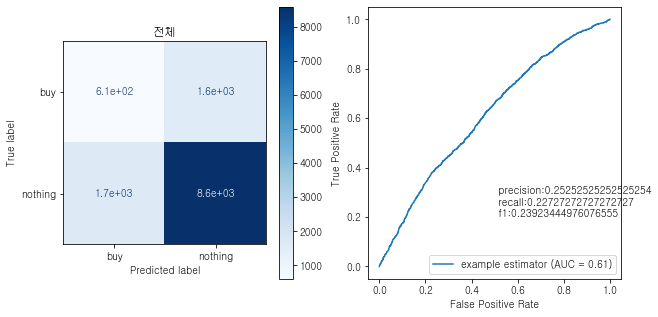

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

roc.plot(ax=ax[1])
conf.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("전체")
text = ' precision:'+str(prfs[i][0][0]) + '\n recall:'+str(prfs[i][1][0])+'\n f1:'+str(prfs[i][2][0])
ax[1].text(0.5, 0.2, text)

count    39016.000000
mean        -0.929780
std         70.560269
min      -1764.371658
25%        -11.558766
50%          0.124942
75%         11.554598
max       2200.000000
dtype: float64

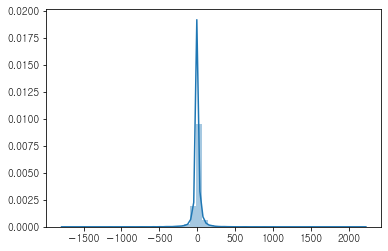

In [55]:
sns.distplot(y_all.apply(lambda x: x.coef_[0][0]))
y_all.apply(lambda x: x.coef_[0][0]).describe()

# 전체 주식 분석

## 전체 뉴스데이터 단어 조사?

In [418]:
y_process = Pipeline([
    ('Buy_Sell_transformer', Buy_Sell_transformer()),
])

x_process = Pipeline([
    ('selector', TextSelector()),
    ('counter', CountVectorizer()),
])

pipeline = Pipeline([
                ('process', x_process),
                ('clf', MultinomialNB())
               ])

tscv = TimeBasedCV(train_period=60, test_period=29, freq='days')
cv_sets = tscv.split(x_all.reset_index(drop=True), validation_split_date=None, date_column='timestamps', gap=0)

pipeline.fit(x_all.iloc[cv_sets[0][0]], y_process.transform(y_all.apply(lambda x: x.coef_[0][0])).iloc[cv_sets[0][0]])

Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 26608 , # test records 12408


Pipeline(memory=None,
         steps=[('process',
                 Pipeline(memory=None,
                          steps=[('selector', TextSelector(text='text')),
                                 ('counter',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=None,
                                                  strip_accen

### 확률이 높은 순

In [419]:
pos_class_prob_sorted = pipeline.get_params()['steps'][1][1].feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = pipeline.get_params()['steps'][1][1].feature_log_prob_[0, :].argsort()

In [423]:
pipeline.get_params()['steps'][1][1].feature_log_prob_[1, :]

array([ -8.65136609, -12.39451517, -13.86085224, ..., -14.95946453,
       -14.95946453, -14.95946453])

In [424]:
cp = pipeline.get_params()['steps'][1][1].feature_log_prob_[1, :].copy()
cp.sort()
np.exp(cp)*100

array([3.18556962e-05, 3.18556962e-05, 3.18556962e-05, ...,
       4.08772294e-01, 4.09313841e-01, 1.10902421e+00])

In [425]:
count_vectorizer = pipeline.steps[0][1].steps[1][1]

In [426]:
pos_words = np.take(count_vectorizer.get_feature_names(), pos_class_prob_sorted)
neg_words = np.take(count_vectorizer.get_feature_names(), neg_class_prob_sorted)

In [427]:
pos_words[:100]

array(['ｍ의', '예치받고', '경제단체장들', '경제단체장', '예치하면', '예치한', '예치할', '경제단체가',
       '예탁결제원의', '경제난에', '예탁금까지', '경제까지', '예탁금도', '예탁금이라는', '예탁원과',
       '예탁주식', '경제금융', '경제규모와', '예치금을', '예측했지만', '경제대책이', '예측했다고',
       '경제부처는', '경제부에', '경제부', '경제보복에', '예측보다', '예측불허는', '예측성과', '경제발전이',
       '경제권이', '예측에는', '경제매체인', '예측하겠다는', '예측하는데', '경제력집중', '예측해보자',
       '경제력', '예측해서', '경제도', '예측치의', '경제권은', '경제국들의', '예후는', '경전철',
       '오가닉티코스메틱', '경쟁회사인', '오가면', '오가야', '오간다', '오갈', '경쟁해볼', '오가는데',
       '오갔던', '오거스틴', '오겠다고', '경쟁하면서', '오고요', '오곡', '경쟁하도록', '경쟁하다가',
       '오규식', '오갔으나', '예측되지만', '경정에', '경제ㆍ증시', '경제구조의', '예후를', '경제구조도',
       '경제교류', '경제관료를', '경제관계장관회의에서', '경제관계장관회의', '경제공동체를', '오가', '경제계와',
       '경제계에서', '옐런', '경제계는', '경제경영', '옛날에는', '경제개발청', '경제개발구에', '경제갈등으로',
       '경제계에서는', '오기까지는', '경제부총리는', '경제분석과장은', '예의주시한다는', '예일대와', '경제자문위',
       '경제인들을', '예전만큼', '예전만해도', '경제위기의', '예정가', '경제위기에서는', '경제위기에서',
       '경제위기설이', '예정됐으며'], dtype='<U50')

In [428]:
neg_words[:100]

array(['kd', '우선순위에서', '쪽방촌', '쪽에는', '반대도', '강등했고', '강등할', '반대론도',
       '반대급부로', '강등하고', '우선매수청구권을', '강등은', '우선라이프스타일', '강등시켰다', '쪽으로는',
       '쪽이나', '쪽이다', '강등하거나', '강등김태완', '쪽박론', '강력했을지', '강문규', '강모주부',
       '강모', '강매하거나', '강매에', '강매를', '강매는', '강력했다', '강매', '우선시하고',
       '쪼그라들었습니다', '반다이남코에', '강렬함에', '쪽과', '쪽도', '강렬하게', '강림중공업', '쪽일까',
       '우선권에', '강동효기자', '쫓아왔다', '반대입장을', '강당으로', '반대파는', '반대편에', '강당도',
       '찌르는', '강대국들이다', '강단이', '우산에', '우산론을', '반대하겠다는', '우산론',
       '강남푸드뱅크마켓센터', '강남진입이', '찍는다는데', '반대표라는', '강대국이고', '반대입장도', '반대일',
       '우선공급한다', '강동은', '반대면', '강동구청에서', '강동구에서', '우상현', '우상향했다', '쫄깃한',
       '쫄병스낵', '강도에서', '쫄병스낵과', '우상향하고', '강도도', '반대이유의', '쫓아내고', '강도높게',
       '강도나', '강미선', '강남지역', '강미선기자', '쪼그라들었는데', '반기업정서를', '반나절', '강서는',
       '우선협상자를', '반납2019년', '강서갑', '짠테크의', '강석훈', '우선협상자', '강사의', '짤막한',
       '짤빵', '강사들은', '강사도', '짧다고', '짧다는', '반납률도', '강북지역에서도'], dtype='<U50')

In [464]:
vector_test_all = count_vectorizer.transform(x_all['text'].iloc[cv_sets[0][1]])

In [485]:
word = pos_words[100]
col_n = count_vectorizer.vocabulary_[word]

print(word)
sample = x_all.iloc[cv_sets[0][1]].reset_index(drop=True)[vector_test_all[:, col_n].toarray().reshape(-1) > 0]

경제예측기관들은


In [476]:
sample

,title,url,press,summary,head,text,timestamps,체결시간,현재가,시가,고가,저가,거래량,date,time,end_price,min30_arrays


### 많이 나온 단어순

In [483]:
import gc
gc.collect()

22

In [448]:
vector_test_all.sum(axis=0).argsort()

matrix([[136163, 161796, 161797, ..., 242027,  85487, 201920]],
       dtype=int64)

In [449]:
many_words = np.take(count_vectorizer.get_feature_names(), list(vector_test_all.sum(axis=0).argsort()))

In [478]:
many_words[0][0][-100:]

array(['등의', '기관은', '삼성바이오로직스', '것은', '카카오', '서비스', '것이다', 'ai', '높은',
       '3월', '코로나', '보는', '저작권자', '감염증', '이재용', '시장', '계획이다', '모두', '세계',
       '삼성', '경제', '연구원은', '예정이다', '최대', 'sk하이닉스', '주요', 'lg화학', '상승',
       '외국인과', '이어', '이상', '신종', '삼성sdi', '전기차', '기업', '따라', '기준', '경우',
       '코스피', '다양한', '가장', '현대차', '등은', '상위', '함께', '관련', '관계자는', '특히',
       '했다', '가운데', '1분기', '서울', '중국', '오전', '보이고', '반도체', '지수는', '등을',
       '시가총액', '같은', '위한', '반면', '배터리', '이번', '전재', '무단', '최근', '따르면',
       '오른', '글로벌', '중이다', '지난해', '이후', '미국', '이라고', '등이', '이날', '말했다',
       '올해', 'com', '밝혔다', '현재', '각각', '위해', '국내', '삼성전자', '대한', 'co',
       '대비', '무단전재', 'kr', '통해', '지난', '재배포', '있는', '금지', '것으로', '코로나19',
       '기자', '있다'], dtype='<U50')

In [480]:
word = many_words[0][0][-3]
col_n = count_vectorizer.vocabulary_[word]

print(word)
x_all.iloc[cv_sets[0][1]].reset_index(drop=True)[vector_test_all[:, col_n].toarray().reshape(-1) > 0]

코로나19


,title,url,press,summary,head,text,timestamps,체결시간,현재가,시가,고가,저가,거래량,date,time,end_price,min30_arrays
0,[마켓인사이트]코로나 뚫고...KB인베스트먼트 인도 에듀테크 베단투(Vedantu...,/news/news_read.nhn?article_id=0004334247&offi...,한국경제,≪이 기사는 04월28일(06:48) 자본시장의 혜안 ‘마켓인사이트’에 게재된 기사...,≪이 기사는 04월28일(06:48) 자본시장의 혜안 ‘마켓인사이트’에 게재된 기사...,KB금융그룹이 인도 온라인 개인지도 플랫폼 베단투(Vedantu)에 투자했다. 신종...,2020-05-04 09:18:00,2.020050e+13,33450.0,33400.0,33450.0,33350.0,13653.0,2020-05-04,09:18:00,33000,"[33250, 33400, 33400, 33350, 33400, 33350, 333..."
1,외국인 12주만에 순매수…귀환 전조 vs 속단 일러,/news/news_read.nhn?article_id=0004671944&offi...,아시아경제,"이밖에 삼성전기(457억원), KB금융(410억원), 호텔신라(400억원), 하나금...",NaN,"[아시아경제 고형광 기자, 송화정 기자] 신종 코로나바이러스감염증(코로나19) 확산...",2020-05-04 11:21:00,2.020050e+13,33300.0,33300.0,33300.0,33250.0,1934.0,2020-05-04,11:21:00,33000,"[33300, 33300, 33300, 33300, 33300, 33300, 334..."
2,카카오뱅크 내년 상장땐 기업가치 4조~9조…김광옥 부대표 IPO 진두진휘,/news/news_read.nhn?article_id=0000536781&offi...,아이뉴스24,"현재 은행주 시가총액은 신한지주가 14조4천억원, KB금융이 13조8천억원, 하나금...",설립 2년6개월만에 빠른 흑자전환…최대주주 카카오와의 시너지 기대,[아이뉴스24 김다운 기자] 전 세계에서도 유례없이 빠르게 성장한 인터넷전문은행 카...,2020-05-04 13:28:00,2.020050e+13,33250.0,33250.0,33300.0,33250.0,1830.0,2020-05-04,13:28:00,33000,"[33200, 33150, 33100, 33100, 33200, 33200, 331..."
3,"코스피, 개인·기관 '사자'에 상승세..증권·의료정밀업종 2%↑",/news/news_read.nhn?article_id=0004633916&offi...,이데일리,반면 LG화학(051910) SK텔레콤(017670) 한국전력(015760) 신한지...,NaN,[이데일리 오희나 기자] 코스피 지수가 기관과 개인의 매수세에 힘입어 상승세를 이어...,2020-05-06 11:21:00,2.020051e+13,32500.0,32550.0,32600.0,32500.0,3294.0,2020-05-06,11:21:00,32700,"[32550, 32550, 32550, 32550, 32550, 32600, 326..."
4,"테크핀·언택트 대표주 카카오, 금융주 제쳤다",/news/news_read.nhn?article_id=0004672920&offi...,아시아경제,"'대장급' 금융사인 신한지주, KB금융 모두를 제쳤다. 같은 기간 신한지주의 시가총...",연초 23위서 13위로 시총 순위 급등신한지주·KB금융 등 금융주 제쳐52주 신고가...,[아시아경제 이민우 기자] 신종 코로나바이러스감염증(코로나19)으로 국내 증시가 들...,2020-05-06 11:52:00,2.020051e+13,32500.0,32500.0,32550.0,32500.0,1475.0,2020-05-06,11:52:00,32700,"[32600, 32650, 32600, 32650, 32600, 32550, 326..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12397,재택근무 카드 꺼낸 최태원·신동빈 회장…재계 확산하나,/news/news_read.nhn?article_id=0000540588&offi...,아이뉴스24,현대차는 최근 클럽이나 주점 등 다중이용시설을 방문한 뒤 코로나19 의심증상이 나타...,"곳곳서 ""코로나19 확진자 증가하자 상황 예의주시""","[아이뉴스24 이연춘 기자] ""근무 환경 변화에 따라 일하는 방식도 당연히 바뀌어야...",2020-05-29 10:50:00,2.020053e+13,97600.0,97500.0,97700.0,97500.0,4385.0,2020-05-29,10:50:00,98000,"[97800, 97700, 97500, 97500, 97500, 97500, 974..."
12398,네이버·카카오 이유있는 주가 강세,/news/news_read.nhn?article_id=0004687945&offi...,아시아경제,이밖에 현대차도 2분기 영업이익 컨센서스가 한 달 전에 비해 16.18% 낮아지며 ...,NaN,[아시아경제 송화정 기자]신종 코로나바이러스감염증(코로나19)으로 기업들의 올해 2...,2020-05-29 11:03:00,2.020053e+13,97400.0,97500.0,97600.0,97400.0,2570.0,2020-05-29,11:03:00,98000,"[97600, 97600, 97600, 97800, 97700, 97700, 977..."
12400,[데스크칼럼]카톡과 자동차,/news/news_read.nhn?article_id=0004687962&offi...,아시아경제,자동차업체 현대차를 추월했다. 오랜 방학 끝의 개학을 하루 앞둔 지난 26일 카카오...,NaN,[아시아경제 전필수 기자]“공부는 안 하니?”하루 종일 집에만 있던 아들이 가장 많...,2020-05-29 11:13:00,2.020053e+13,97400.0,97500.0,97500.0,97400.0,402.0,2020-05-29,11:13:00,98000,"[97700, 97900, 97800, 97900, 97700, 97800, 977..."
12402,"뛰는 동학개미, 나는 원정개미",/news/news_read.nhn?article_id=0004687997&offi...,아시아경제,"그나마 개인 순매수 2, 4, 5위인 삼성전자(1조1249억원)와 SK하이닉스(43...",국내 매수 상위 7개 수익률 4.73%해외직구는 17.84%…4배 차이,[아시아경제 오주연 기자] 신종 코로나바이러스감염증(코로나19) 이후의 반등장에서 ...,2020-05-29 11:26:00,2.020053e+13,97700.0,97800.0,97800.0,97700.0,2333.0,2020-05-29,11:26:00,98000,"[97400, 97500, 97500, 97300, 97500, 97600, 975..."
